In [4]:
import h5py
import astropy.units as u
from galpy.util import bovy_plot, bovy_coords
import pandas
from scipy.optimize import minimize
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# At the Solar Radius

In [8]:
gal0= h5py.File('latte/lsr-1-rslice-0.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal1= h5py.File('latte/lsr-1-rslice-1.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal2= h5py.File('latte/lsr-1-rslice-2.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal3= h5py.File('latte/lsr-1-rslice-3.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal4= h5py.File('latte/lsr-1-rslice-4.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal5= h5py.File('latte/lsr-1-rslice-5.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal6= h5py.File('latte/lsr-1-rslice-6.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal7= h5py.File('latte/lsr-1-rslice-7.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal8= h5py.File('latte/lsr-1-rslice-8.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal9= h5py.File('latte/lsr-1-rslice-9.m12f-res7100-md-sliced-gcat-dr2.hdf5','r')
gal=[gal0,gal1,gal2,gal3,gal4,gal5,gal6,gal7,gal8,gal9]

In [52]:
ra= gal0['ra_true'].value
dec= gal0['dec_true'].value
d= 1./gal0['parallax_true'].value # True distances from the simulation
ra= gal0['ra_true'].value
dec= gal0['dec_true'].value
pd= gal0['pmdec_true'].value
pr= gal0['pmra_true'].value
rv= gal0['radial_velocity_true'].value

x0=-7.101408
y0=-4.1
z0=0.
r0= sqrt(x0**2+y0**2)

vx0= -114.035072
vy0= 208.726669
vz0= 5.063526

lb= bovy_coords.radec_to_lb(ra,dec,degree=True,epoch=None)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],d,degree=True)
pmllbb= bovy_coords.pmrapmdec_to_pmllpmbb(pr,pd,ra,dec,degree=True,epoch=None)
UVW= bovy_coords.vrpmllpmbb_to_vxvyvz(rv,pmllbb[:,0],pmllbb[:,1],lb[:,0],lb[:,1],d,degree=True)

ang= 30*pi/180
rot= array([[cos(ang),sin(ang)],[-sin(ang),cos(ang)]])

vxy0= dot(rot,[vx0,vy0]).T
xy0= np.dot(rot,[x0,y0]).T

v0= sqrt(vxy0[0]**2+vxy0[1]**2)

RpZ= bovy_coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],r0,z0)
Vcy= bovy_coords.vxvyvz_to_galcencyl(UVW[:,0],UVW[:,1],UVW[:,2],XYZ[:,0]-xy0[0],XYZ[:,1]-xy0[1],XYZ[:,2]-z0,
                                     array([vxy0[0],vxy0[1],vz0]),r0,z0)


mask= d<1.

[3.40817994 0.03840453 0.1956182  0.56374014 0.49600317]


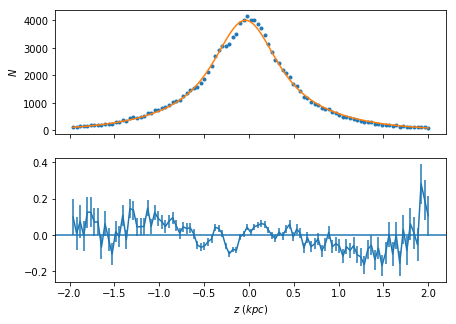

In [129]:
R= sqrt(XYZ[:,0]**2+XYZ[:,1]**2)
mask1= (R<0.25)*(abs(XYZ[:,2])<2.)

def nloglikelihood(params,data):
        N,z= data
        model= n_model(params,z)
        if (params[4]>5. or params[4]<0):
            return np.inf
        if (params[3]>10. or params[3]<0.):
            return np.inf
        if (params[2]<0. or params[2]>5.):
            return np.inf
        if (params[1]<-0.1 or params[1]>0.1):
            return np.inf
        loglike= -model+N*np.log(model)
        return -np.sum(loglike)
        
def n_model(params,zdata):
        ln_n0,zsun,H1,f,H2 = params
        n0= 10.**(ln_n0)
        return n0*(1./np.cosh((zdata+zsun)/(2.*H1))**2+f*1./np.cosh((zdata+zsun)/(2.*H2))**2)

def calc_sechfit(data,guess):
        fit= minimize(lambda x: nloglikelihood(x,data),guess)
        return fit.x

rho,z_edges=histogram(XYZ[mask1,2].T,bins=101)
z=diff(z_edges)+z_edges[:-1]

g= [3.5,0.,0.3,0.,1.]
m= calc_sechfit([rho,z],g)
model= n_model(m,z)

print(m)

fig,(ax1,ax2) = subplots(2,1,sharex=True)
ax1.plot(z,rho,'.')
ax1.plot(z,n_model(m,z))
ax1.set_ylabel('$N$')
ax2.set_xlabel('$z\,\,(kpc)$')

ax2.errorbar(z,(rho-model)/model,sqrt(rho)/model)
ax2.axhline(0.)

savefig('plots/VNcount.pdf')

### Calculate the asymmetry in the number counts

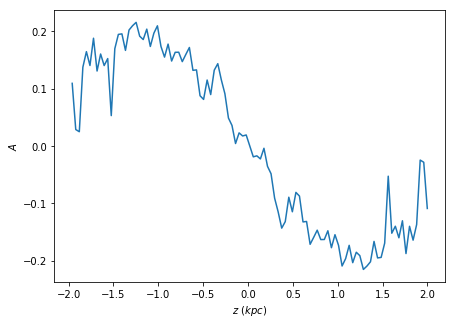

In [128]:
plot(z,(rho-rho[::-1])/(rho+rho[::-1]))
ylabel('$A$')
xlabel('$z \,\,(kpc)$')
savefig('plots/asymmetry.pdf')

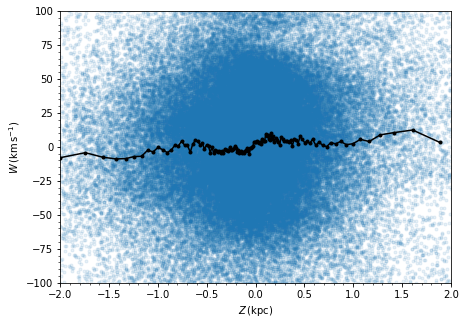

In [53]:
figsize(7,5)
bovy_plot.bovy_plot(XYZ[mask1,2],Vcy[mask1,2]+vz0,'.',alpha=0.1,
                    xrange=[-2.,2.],
                    yrange=[-100.,100.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')
sindx= numpy.argsort(XYZ[mask1,2])
wind= 1000
showskip= wind
running_median= pandas.DataFrame(UVW[mask1,2][sindx]+vz0)\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(func=lambda x: numpy.nanmedian(x),raw=True)
plot(XYZ[mask1,2][sindx][::showskip],running_median[::showskip],
     'k.-')

In [54]:
running_median_err= pandas.DataFrame(UVW[mask,2][sindx])\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: 1.4826*numpy.nanmedian(numpy.fabs(x-numpy.nanmedian(x)))
                               /numpy.sqrt(numpy.sum(True^numpy.isnan(x))),raw=True)

<ErrorbarContainer object of 3 artists>

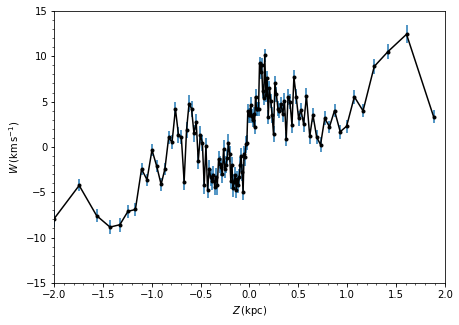

In [56]:
figsize(7,5)
bovy_plot.bovy_plot(XYZ[mask1,2][sindx][::showskip],running_median[::showskip],
                    'k.-',
                    xrange=[-2.,2.],
                    yrange=[-15.,15.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')
errorbar(XYZ[mask1,2][sindx][::showskip],numpy.array(running_median[::showskip]),
         yerr=numpy.array(running_median_err[::showskip]),
         marker='None',ls='None')

### Calculate the Breathing and Bending mode amplitudes

In [67]:
zz= linspace(-2,2,61)
vz= zeros(len(zz))
vz_err= zeros(len(zz))
W= UVW[mask1,2]

In [79]:
def bootstrap(x,n_resamp):
    i= random.randint(0,len(x)-1,(n_resamp,len(x)))
    x_boot= x[i]
    m_boot= np.nanmedian(x_boot,axis=1)
    m= np.mean(m_boot)
    sigma= np.std(m_boot)
    return m,sigma

for i in range(len(zz)-1):
    vz[i],vz_err[i]= bootstrap(W[(XYZ[mask1,2]>zz[i])*(XYZ[mask1,2]<zz[i+1])],10000)

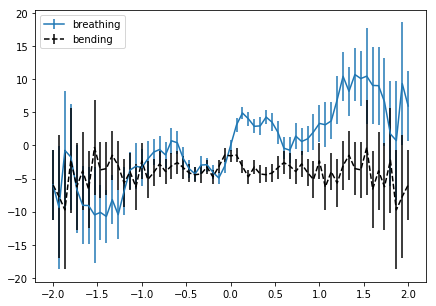

In [120]:
vbr= 0.5*(vz-vz[::-1])
vbe= 0.5*(vz+vz[::-1])
vb_err= sqrt(vz_err**2+vz_err[::-1]**2)

errorbar(zz,vbr,vb_err,label='breathing')

errorbar(zz,vbe,vb_err,color='k',ls='--',label='bending')
legend(loc=2)
savefig('plots/breathing-bending.pdf')

In [85]:
clusters= h5py.File('LATTE_labeled_xyz_eps0.01normed_Npts50.h5py','r')
list(clusters.keys())

label= clusters['dblabels'].value
xyz= clusters['positions'].value 

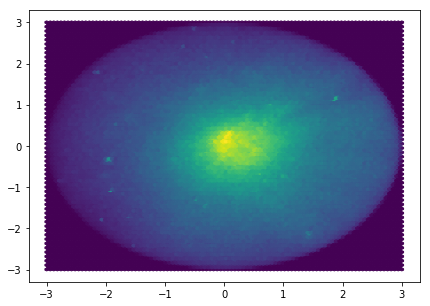

In [86]:
hexbin(xyz[:,0],xyz[:,1])

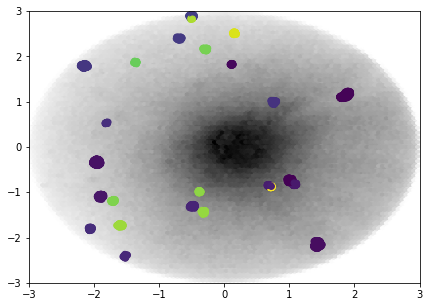

In [99]:
R= sqrt(xyz[:,0]**2+xyz[:,1]**2)
cl= label!=-1
bckgrnd= label==-1
hexbin(XYZ[bckgrnd,0],XYZ[bckgrnd,1],cmap='gray_r')
scatter(xyz[cl,0][R[cl]>1.],xyz[cl,1][R[cl]>1.],c=label[cl][R[cl]>1.])

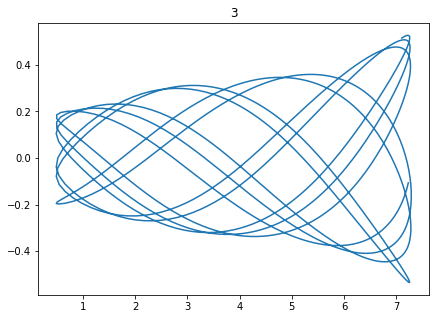

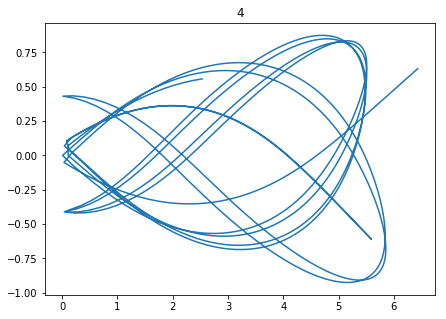

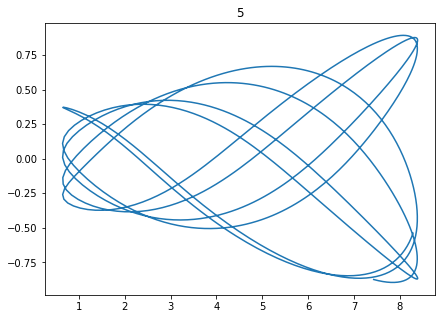

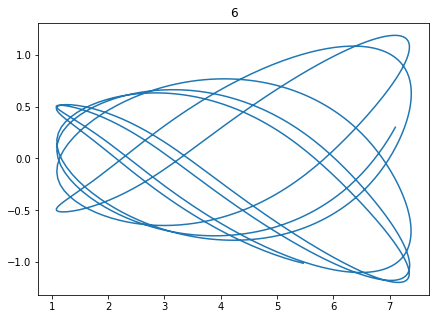

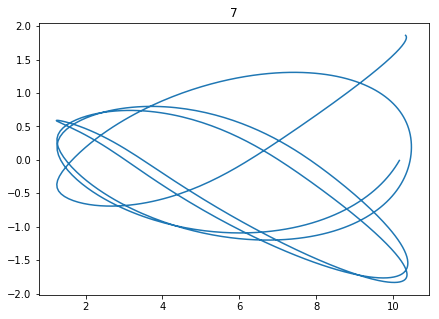

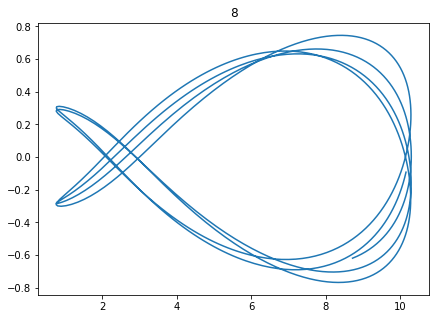

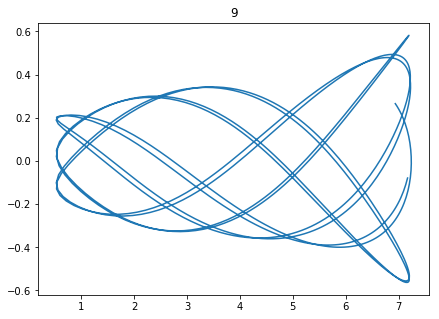

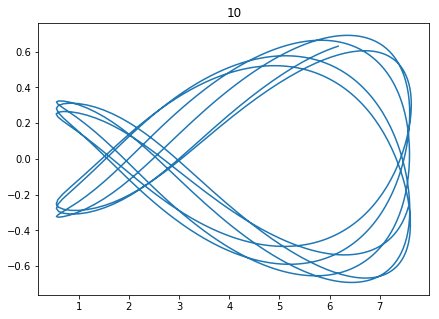

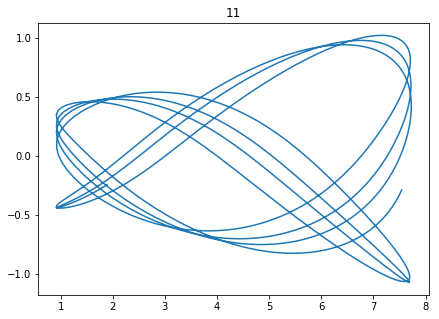

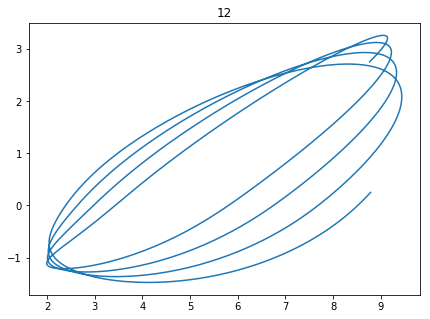

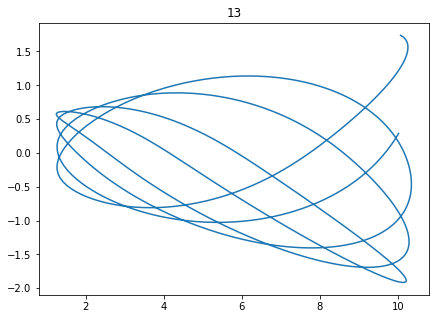

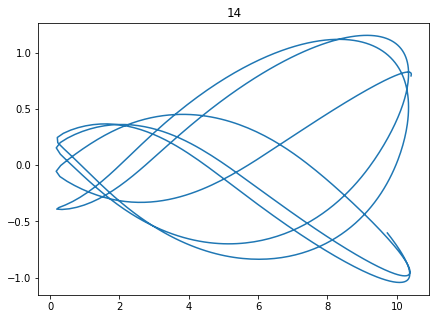

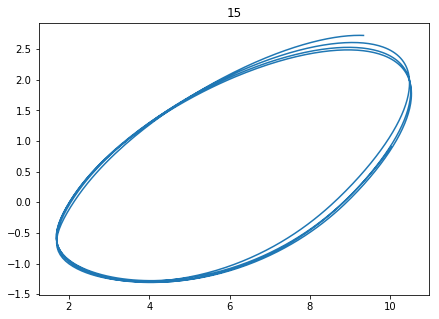

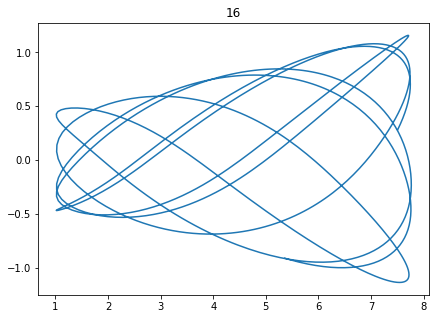

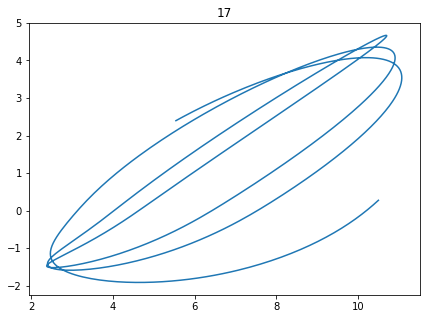

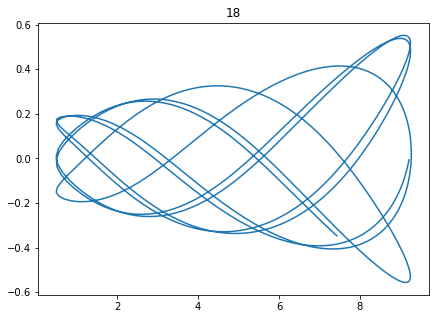

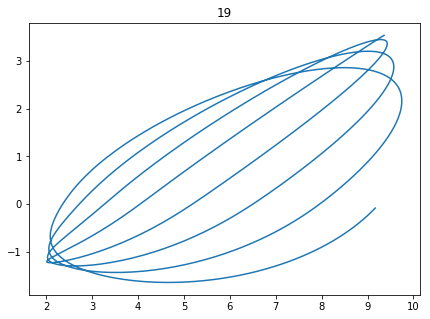

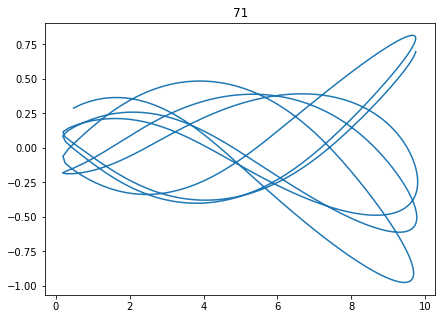

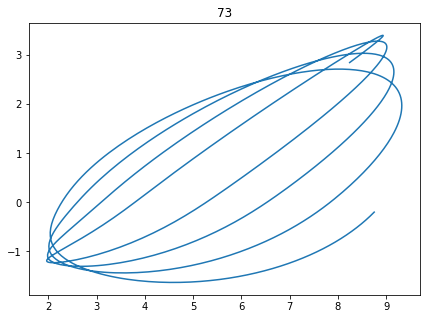

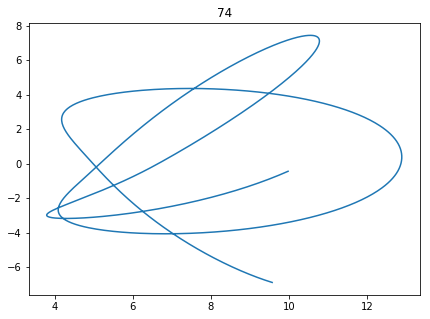

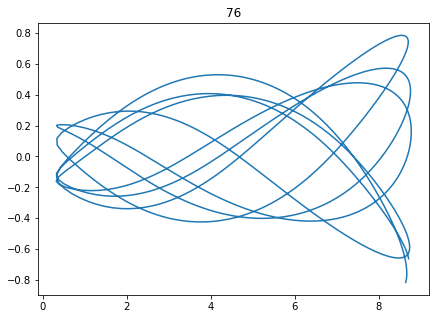

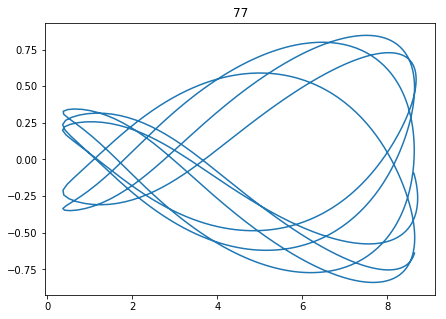

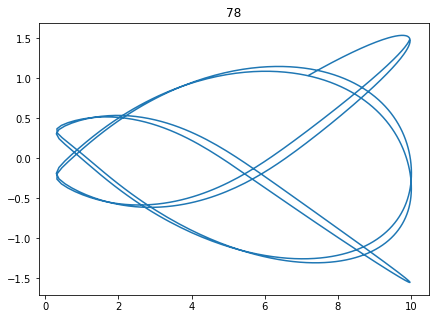

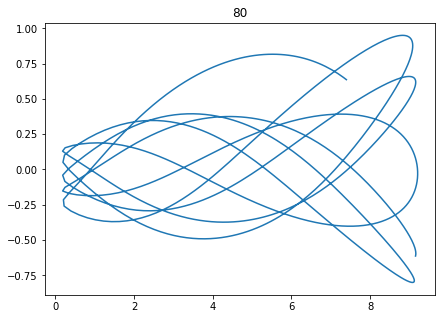

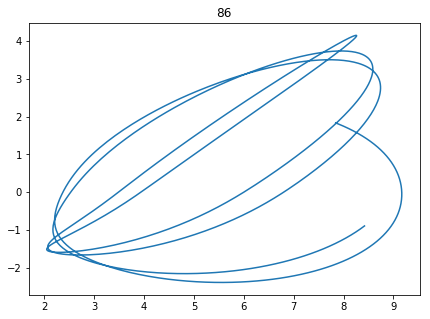

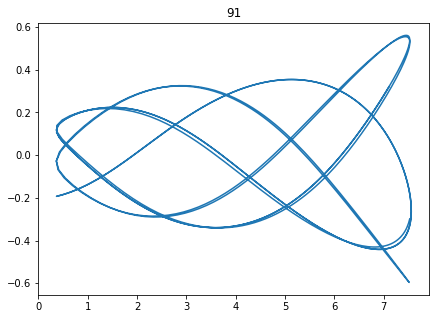

In [119]:
from galpy.potential import MWPotential2014
from galpy.orbit import Orbit
tt= linspace(0,-500,1000)*u.Myr

for grp in unique(label[cl][R[cl]>1.]):
    rpz= [mean(RpZ[:,0][label==grp][R[label==grp]>1.]),mean(RpZ[:,1][label==grp][R[label==grp]>1.]),
          mean(RpZ[:,2][label==grp][R[label==grp]>1.])]
    vrpz= [mean(Vcy[:,0][label==grp][R[label==grp]>1.]),mean(Vcy[:,0][label==grp][R[label==grp]>1.]),
           mean(Vcy[:,0][label==grp][R[label==grp]>1.])]
    o= Orbit(vxvv=[rpz[0]*u.kpc,vrpz[0]*(u.km/u.s),vrpz[1]*(u.km/u.s),rpz[2]*u.kpc,
                   vrpz[2]*(u.km/u.s),rpz[1]*u.rad])
    o.integrate(tt,MWPotential2014)
    figure()
    plot(o.R(tt),o.z(tt))
    title(grp)